<a href="https://www.kaggle.com/code/sakshi757/netflix-binge-worthy-insights?scriptVersionId=146193327" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Binge-Worthy Insights: The Netflix Data Chronicles


In [1]:
#Import Necessary Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
print('Shape of Dataset:',df.shape)
print('Number of Duplicate Rows:',df.duplicated().sum())

Shape of Dataset: (8807, 12)
Number of Duplicate Rows: 0


## Handling Missing Values

There are missing values in six columns. Three columns have a significant number of missing rows.

In [4]:
print("Missing Value Counts:")
df.isna().sum()

Missing Value Counts:


show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

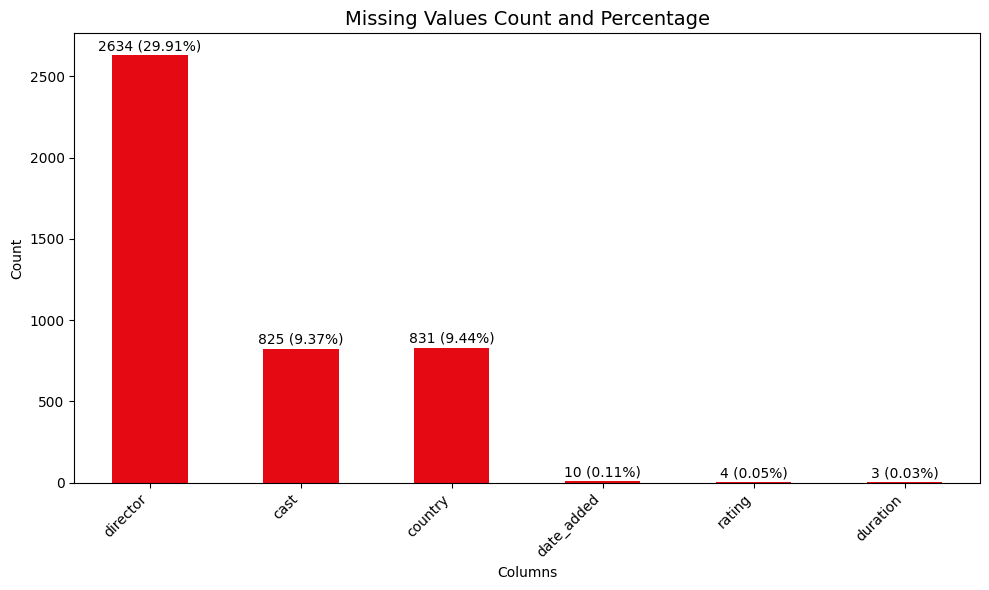

In [5]:
def plot_missing_values(df, columns):
    # Calculate the count and percentage of missing values for each column
    missing_data = df[columns].isnull().sum()
    total_rows = len(df)
    missing_percentage = (missing_data / total_rows) * 100

    # Create a DataFrame to store the missing data info
    missing_info = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage': missing_percentage})

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    missing_info['Missing Count'].plot(kind='bar', ax=ax, label='Missing Count', color='#E50914')
    ax.set_title('Missing Values Count and Percentage', size = 14)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Count')

    # Add labels with counts and percentages on top of the bars
    for i, count in enumerate(missing_info['Missing Count']):
        percent = missing_info['Missing Percentage'][i]
        label = f'{count} ({percent:.2f}%)'  # Modify the label to include both count and percentage
        ax.text(i, count + 10, label, ha='center', va='bottom', fontsize=10, color='black')

    plt.xticks(range(len(columns)), columns, rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(False)
    plt.show()


columns_with_missing_values = df.columns[df.isnull().any()].tolist()
plot_missing_values(df, columns_with_missing_values)



- It appears that there are instances where missing values originally meant for the "duration" column have been mistakenly recorded in the "rating" column <br> <br>

- To address this issue, the missing values in the "duration" column have been corrected with appropriate values, while the erroneous data in the "rating" column has been replaced with NaNs. The "rating" column now contains five missing values, whereas the "duration" column is devoid of any <br><br>

- In order to maintain data integrity, rows containing missing values in both the "date_added" and "rating" columns have been removed, as these columns exhibit a relatively small percentage of missing values

In [6]:
df[df['duration'].isnull()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...


- Missing values in "director" and "cast" columns are replaced with "Unknown" <br> <br>

- Missing values in "country" column are replaced with most common occurance aka mode

In [7]:
# Replace null values in 'duration' with values from 'rating' column where 'duration' is null
df['duration'].fillna(df['rating'], inplace=True)

# Replace rating values equal to duration with NaN
df['rating'] = np.where(df['rating'] == df['duration'], np.nan, df['rating'])

# Drop Columns With Missing date_added or rating
df.dropna(subset=['date_added', 'rating'], how='any', inplace=True)

# Replace missing values in "Director" and "Cast" columns with "Unknown"
df["director"].fillna("Unknown", inplace=True)
df["cast"].fillna("Unknown", inplace=True)

# Replace missing values in the "Country" column with the mode (most common occurrence)
mode_country = df["country"].mode()[0]
df["country"].fillna(mode_country, inplace=True)

# Verify that the missing values have been handled
missing_values_count = df.isnull().sum()
print("Missing Values Count After Cleaning:")
print(missing_values_count)


Missing Values Count After Cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


## Distribution and Count of Movies vs TV Shows

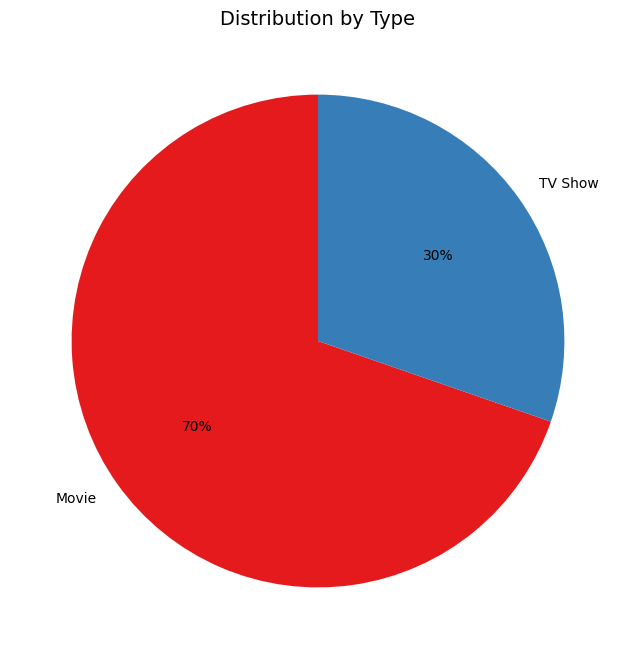

In [8]:
# Count the number of entries by 'type'
type_counts = df['type'].value_counts().reset_index()
type_counts.columns = ['Type', 'Count']

# Create a pie chart
plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.pie(type_counts['Count'], labels=type_counts['Type'], autopct='%1.0f%%', startangle=90, colors=sns.color_palette('Set1'))

# Add a title
plt.title('Distribution by Type', size = 14)

# Show the chart
plt.show()


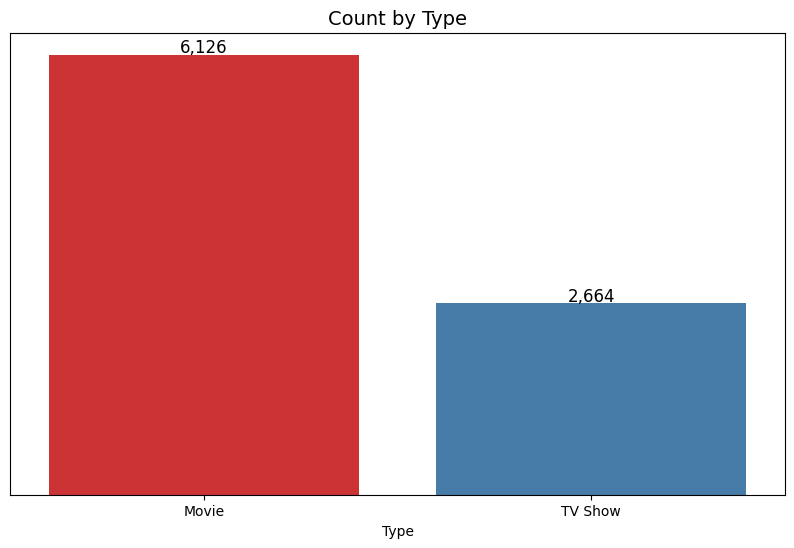

In [9]:
# Count the number of entries by 'type'
type_counts = df['type'].value_counts().reset_index()
type_counts.columns = ['Type', 'Count']

# Create a bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=type_counts, x='Type', y='Count', palette='Set1')
plt.title('Count by Type', size = 14)
plt.xlabel('Type')
plt.ylabel('')  # Empty string to hide the y-axis label

# Hide the y-axis ticks and labels
plt.yticks([])

# Display the count values inside the bars with commas
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count:,}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Show the chart
plt.grid(False)
plt.show()




## Creating New Columns: Year, Quarter, Month, Day, Day of Week 

In [10]:

# Separate month, day, and year of date_added and handle inconsistent date formats
df[['month_added', 'day_added', 'year_added']] = df['date_added'].str.strip().str.split(' ', expand=True)
df['year_added'] = df['year_added'].astype('int64')

# Remove commas from day_added
df['day_added'] = df['day_added'].str.split(',').str[0].str.replace(',', '')

# Parse 'date_added' column with a flexible date format
df['date_added'] = pd.to_datetime(df['date_added'], format='%B %d, %Y', errors='coerce')

# Create a day_of_week column
df['day_of_week'] = df['date_added'].dt.day_name()

month_to_quarter = {
    'January': 'Q1',
    'February': 'Q1',
    'March': 'Q1',
    'April': 'Q2',
    'May': 'Q2',
    'June': 'Q2',
    'July': 'Q3',
    'August': 'Q3',
    'September': 'Q3',
    'October': 'Q4',
    'November': 'Q4',
    'December': 'Q4'
}

# Create the 'quarter' column by mapping 'month_added' to quarters
df['quarter'] = df['month_added'].map(month_to_quarter)


## Movies and TV Shows By Year Added


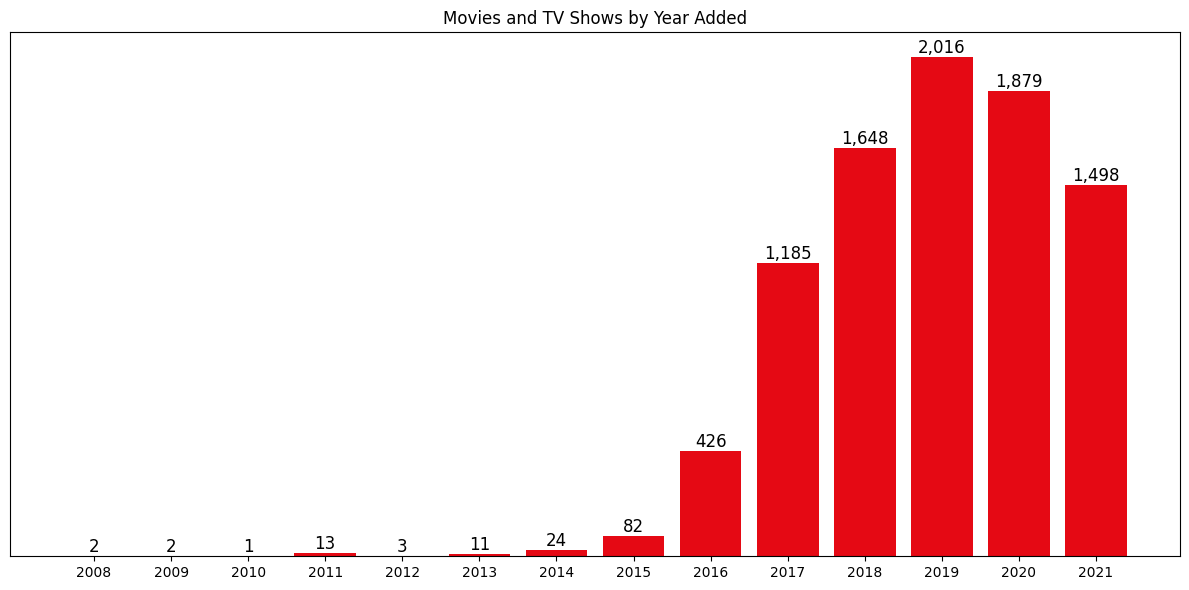

In [11]:

# Count the number of entries by 'year_added'
yearly_counts = df['year_added'].value_counts().reset_index()
yearly_counts.columns = ['Year', 'Count']

# Create a bar chart with a single color
plt.figure(figsize=(12, 6))
plt.bar(yearly_counts['Year'], yearly_counts['Count'], color='#E50914') 
plt.title('Movies and TV Shows by Year Added')

# Hide the y-axis ticks and labels
plt.yticks([])

# Display the count values above each bar with commas
for i, count in enumerate(yearly_counts['Count']):
    formatted_count = '{:,}'.format(count)  # Format the count with commas
    plt.text(yearly_counts['Year'][i], count, formatted_count, ha='center', va='bottom', fontsize=12, color='black')

# Show the chart
plt.xticks(yearly_counts['Year'])
plt.tight_layout()
plt.grid(False)
plt.show()


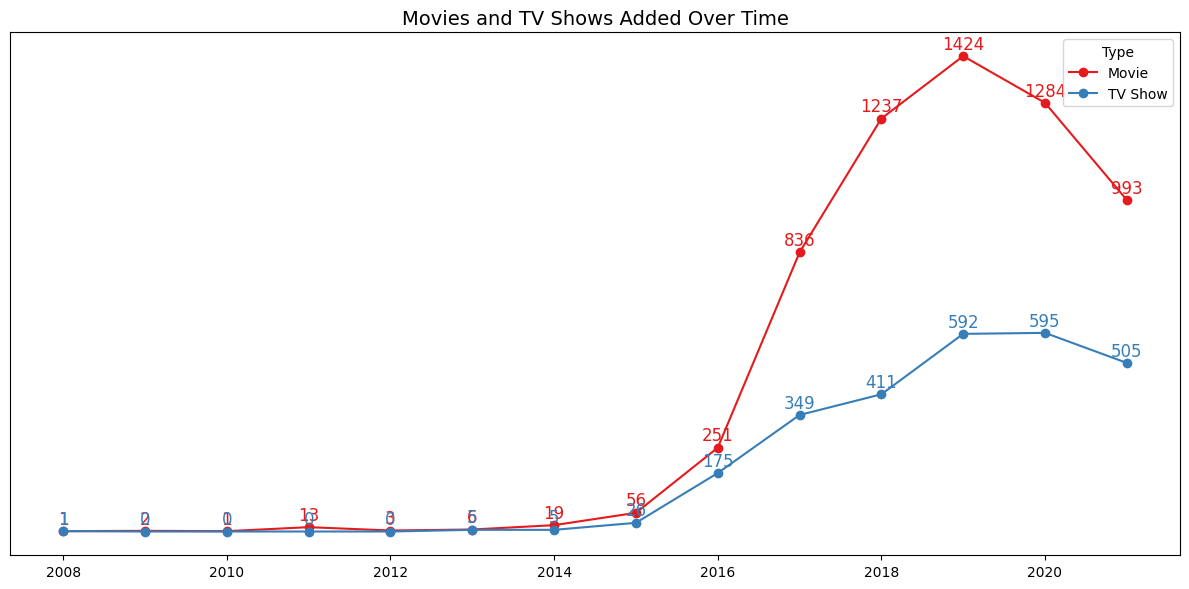

In [12]:
# Count the number of entries by 'type' for each 'year_added'
count_by_type_year = df.groupby(['year_added', 'type']).size().unstack(fill_value=0)

# Create a larger figure
plt.figure(figsize=(12, 6))

# Define colors
colors = sns.color_palette("Set1", n_colors=len(count_by_type_year.columns))

for i, col in enumerate(count_by_type_year.columns):
    plt.plot(
        count_by_type_year.index, 
        count_by_type_year[col], 
        label=col, 
        marker='o', 
        linestyle='-', 
        markersize=6,
        color=colors[i],
    )
    for year, count in zip(count_by_type_year.index, count_by_type_year[col]):
        plt.text(year, count + 10, str(count), ha='center', va='bottom', fontsize=12, color=colors[i])

# Customize the chart
plt.title('Movies and TV Shows Added Over Time', size=14)
plt.legend(title='Type')

# Show the chart
plt.yticks([])
plt.grid(False)
plt.tight_layout()
plt.show()

## Movies and TV Shows Added in the Same Year as Release Year
- The count of movies and TV shows added in the same year as their release has been steadily rising <br> <br>

- The percentage of movies added in the same year as their release appears to be decreasing, while the percentage of TV shows added in the same year as their release is on the upswing

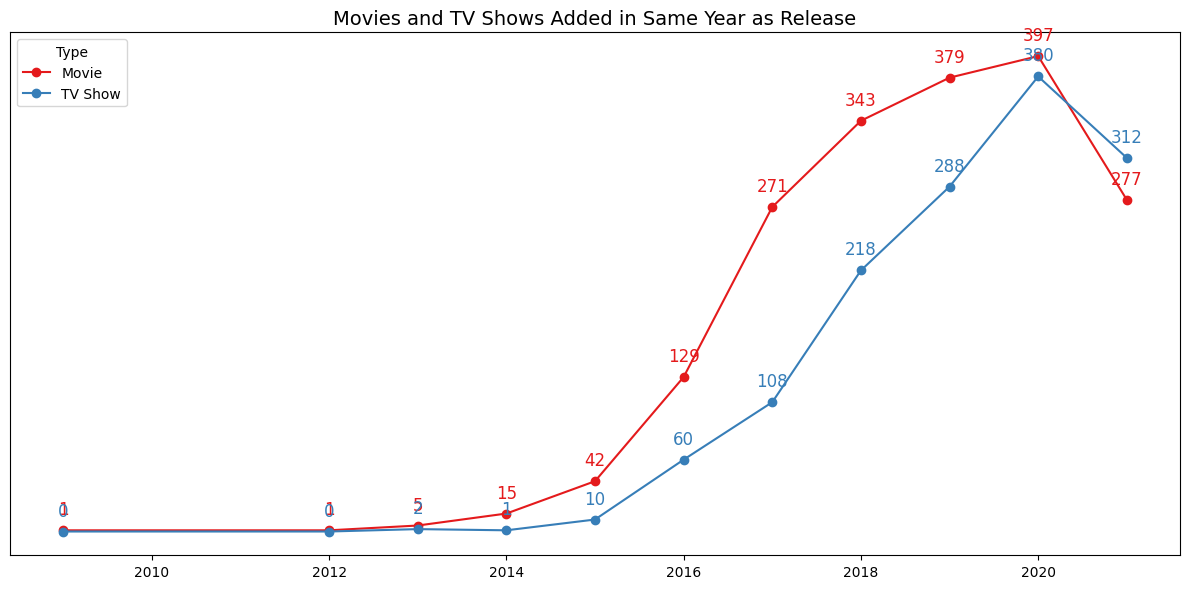

In [13]:
# Movied Added in the Same Year As Release
same_year_added_df = df[df['release_year'] == df['year_added']]

# Group the data by 'year_added', 'type' and count the number of titles added in each year
counts_by_year_type = same_year_added_df.groupby(['year_added', 'type']).size().unstack(fill_value=0)

# Create a larger figure
plt.figure(figsize=(12, 6))

# Define colors
colors = sns.color_palette("Set1", n_colors=len(counts_by_year_type.columns))

# Create a separate line chart for movies and TV shows
for i, col in enumerate(counts_by_year_type.columns):
    plt.plot(
        counts_by_year_type.index,
        counts_by_year_type[col],
        label=col,
        marker='o',
        linestyle='-',
        markersize=6,
        color=colors[i],
    )
    for year, count in zip(counts_by_year_type.index, counts_by_year_type[col]):
        plt.text(year, count + 10, f'{count:,}', ha='center', va='bottom', fontsize=12, color=colors[i])

# Customize the chart
plt.title('Movies and TV Shows Added in Same Year as Release', size=14)
plt.legend(title='Type')

# Show the chart
plt.yticks([])
plt.grid(False)
plt.tight_layout()
plt.show()


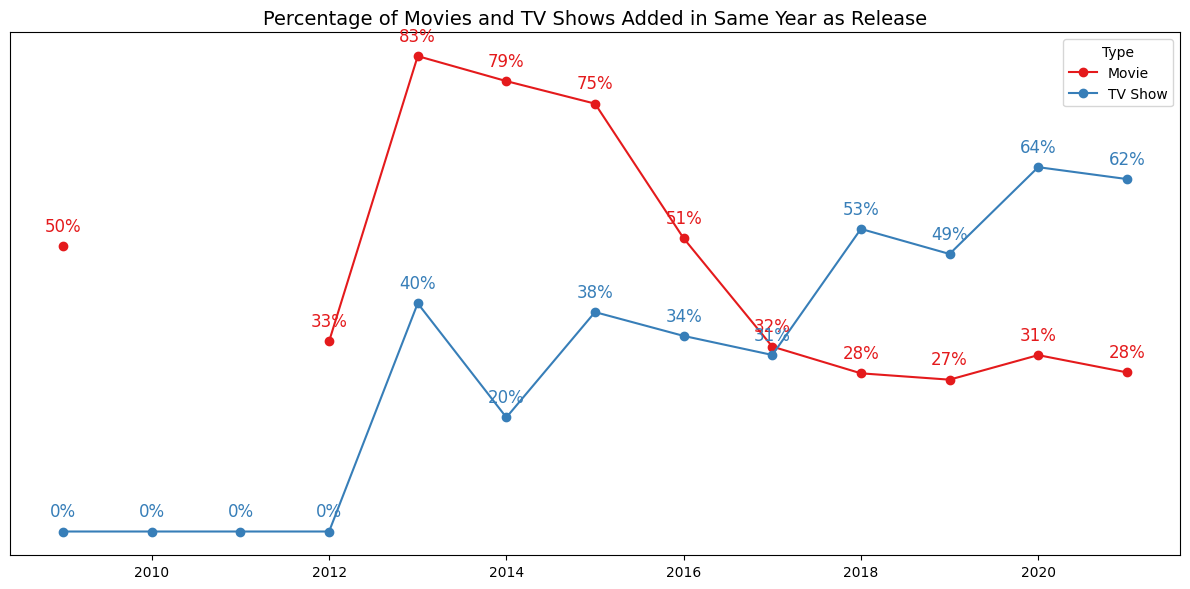

In [14]:
# Filter rows where release_year is equal to year_added
same_year_added = df[df['release_year'] == df['year_added']]

# Group the data by 'year_added' and 'type' and calculate the percentage
percentage_by_year_type = (
    same_year_added.groupby(['year_added', 'type']).size() /
    df.groupby(['year_added', 'type']).size()
).unstack(fill_value=0) * 100

# Create a larger figure
plt.figure(figsize=(12, 6))

# Define colors
colors = sns.color_palette("Set1", n_colors=len(percentage_by_year_type.columns))

# Create a separate line chart for movies and TV shows
for i, col in enumerate(percentage_by_year_type.columns):
    plt.plot(
        percentage_by_year_type.index,
        percentage_by_year_type[col],
        label=col,
        marker='o',
        linestyle='-',
        markersize=6,
        color=colors[i],
    )
    for year, percent in zip(percentage_by_year_type.index, percentage_by_year_type[col]):
        if pd.notna(percent):
            plt.text(year, percent + 2, f'{percent:.0f}%', ha='center', va='bottom', fontsize=12, color=colors[i])

# Customize the chart
plt.title('Percentage of Movies and TV Shows Added in Same Year as Release', size=14)
plt.legend(title='Type')

# Show the chart
plt.yticks([])
plt.grid(False)
plt.tight_layout()
plt.show()


## Movies and TV Shows Added By Quarter
Netflix has historically released most movies and tv shows in Q4 compared to other quarters. This could be because of the following reasons: <br> 

- Holiday Season: The Q4 period includes the holiday season, which is a time when people often have more leisure time for entertainment. This could lead to streaming platforms like Netflix strategically releasing more content during this period to attract viewers  <br> <br>

- Awards Season: Many award-worthy films and TV shows are released towards the end of the year to qualify for awards such as the Oscars. Streaming platforms may aim to showcase such content during Q4 to gain recognition and nominations  <br> <br>

- Advertising and Promotion: Q4 is a time when companies tend to allocate more resources to marketing and advertising. Streaming platforms may invest in promoting their new releases to take advantage of increased consumer spending during the holiday season  <br> <br>

- Viewer Behavior: Viewer behavior may change during the colder months. People tend to spend more time indoors, which can lead to increased consumption of entertainment content. Streaming platforms respond to this demand by offering more new titles <br> <br>

- Content Licensing and Agreements: The availability of content can be influenced by licensing agreements and contracts with studios and production companies. These agreements may result in more content becoming available towards the end of the year  <br> <br>

- Subscriber Retention: Streaming platforms often aim to retain subscribers, especially during the end-of-year holiday season when people are more likely to sign up or renew subscriptions. Offering a wide range of new content can help in subscriber retention  <br> <br>

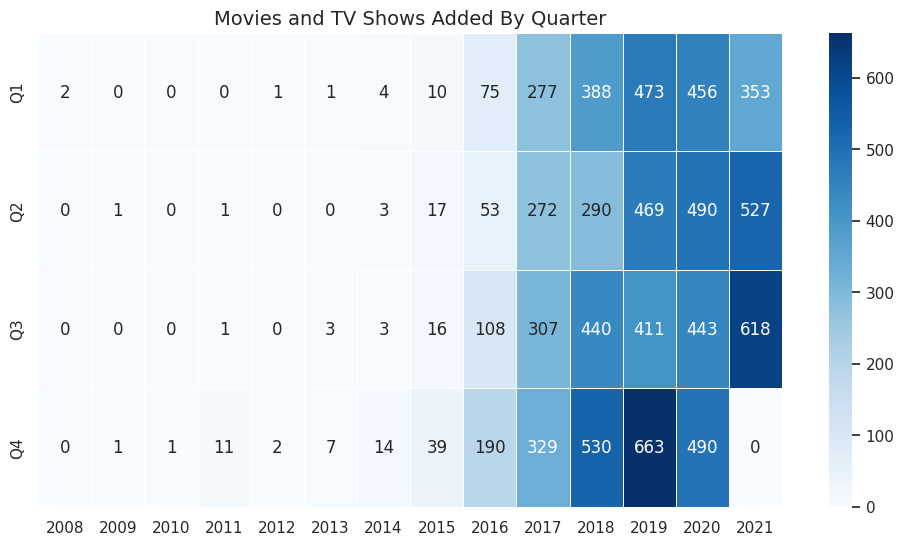

In [15]:
# Define the order of quarters
quarters_order = ['Q1', 'Q2', 'Q3', 'Q4']

# Pivot the DataFrame by quarter and year
pivot_table = df.pivot_table(index='quarter', columns='year_added', aggfunc='size', fill_value=0)
pivot_table = pivot_table.reindex(quarters_order, axis=0)

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.set_theme()

# Customize the heatmap
ax = sns.heatmap(pivot_table, annot=True, fmt="d", linewidths=.5, cbar=True, cmap=sns.color_palette("Blues", as_cmap=True))

# Set axis labels and title
ax.set_title('Movies and TV Shows Added By Quarter', size=14)

# Fix the margins and plot limits to ensure all values are visible
ax.set_ylim(len(quarters_order), 0)
plt.subplots_adjust(top=0.9)  # Adjust the top margin

plt.xlabel("")
plt.ylabel("")

# Show the heatmap
plt.show()


## Movies and TV Shows Added by Day of Week
- Netflix has historically added more movies and tv shows on Friday. This makes sense as people have more leisure time on weekends to watch new content

- However, this changed in 2020 and 2021 as Netflix started adding more content from Wednesday onwards. The COVID-19 pandemic in 2020 and 2021 led to lockdowns and restrictions, resulting in more people staying at home, thus increasing entertainment consumption during the week

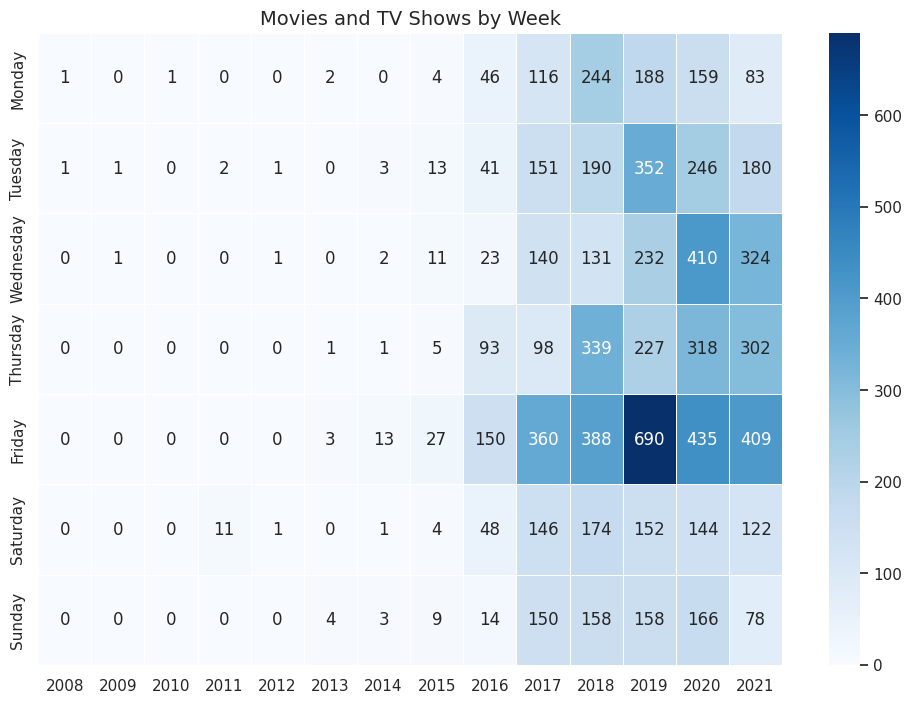

In [16]:
# Define the order of days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Pivot the DataFrame by day of the week and year
pivot_table = df.pivot_table(index='day_of_week', columns='year_added', aggfunc='size', fill_value=0)
pivot_table = pivot_table.reindex(days_order, axis=0)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.set_theme()

# Customize the heatmap
ax = sns.heatmap(pivot_table, annot=True, fmt="d", linewidths=.5, cbar=True, cmap=sns.color_palette("Blues", as_cmap=True))

# Set axis labels and title
ax.set_title('Movies and TV Shows by Week', size=14)

# Fix the margins and plot limits to ensure all values are visible
ax.set_ylim(len(days_order), 0)
plt.subplots_adjust(top=0.9)  # Adjust the top margin
plt.xlabel("")
plt.ylabel("")
# Show the heatmap
plt.show()


## Movies and TV Shows by Rating
- Most movies and tv shows are targeted towards Mature Audience and people over 14 <br> <br>
- Netflix has several R and PG rated movies , but not many tv shows

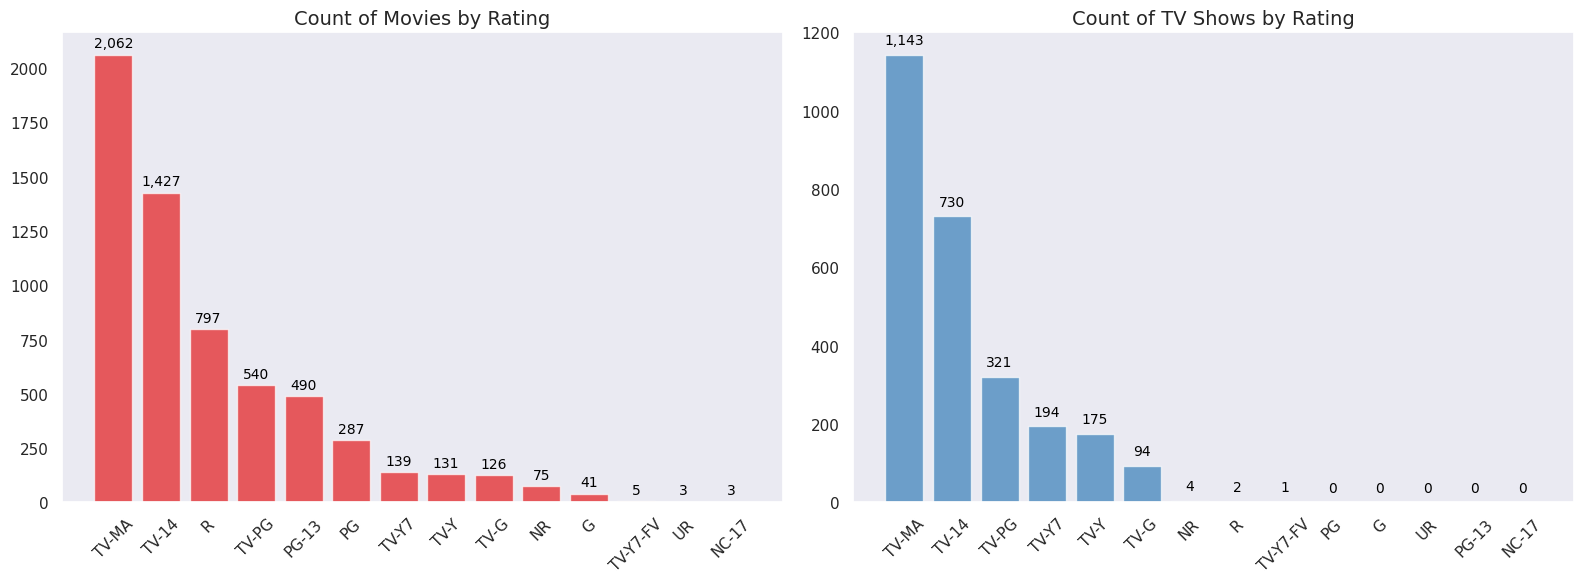

In [17]:
# Filter rows for movies and TV shows
movies = df[df['type'] == 'Movie']
tv_shows = df[df['type'] == 'TV Show']

# Count the number of movies and TV shows for each rating
movie_counts = movies['rating'].value_counts().sort_values(ascending=False)
tv_show_counts = tv_shows['rating'].value_counts().sort_values(ascending=False)

# Combine the ratings from both movie and TV show counts
all_ratings = set(movie_counts.index).union(set(tv_show_counts.index))

# Ensure that both movie and TV show counts have the same index
movie_counts = movie_counts.reindex(all_ratings, fill_value=0)
tv_show_counts = tv_show_counts.reindex(all_ratings, fill_value=0)

# Sort ratings by count in descending order
movie_counts = movie_counts.sort_values(ascending=False)
tv_show_counts = tv_show_counts.sort_values(ascending=False)

# Create a larger figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = sns.color_palette("Set1")

# Create the vertical bar chart for movies (color it blue)
ax1.bar(movie_counts.index, movie_counts.values, color=colors[0], alpha=0.7)

# Customize the chart for movies
ax1.set_title('Count of Movies by Rating', size=14)
ax1.grid(False)

# Display the counts on top of the bars
for i, v in enumerate(movie_counts.values):
    ax1.text(i, v + 20, f'{v:,.0f}', ha='center', va='bottom', fontsize=10, color='black')

# Create the vertical bar chart for TV shows (color it red)
ax2.bar(tv_show_counts.index, tv_show_counts.values, color=colors[1], alpha=0.7)

# Customize the chart for TV shows
ax2.set_title('Count of TV Shows by Rating', size=14)
ax2.grid(False)

# Display the counts on top of the bars
for i, v in enumerate(tv_show_counts.values):
    ax2.text(i, v + 20, f'{v:,.0f}', ha='center', va='bottom', fontsize=10, color='black')

# Rotate x-axis labels for better readability
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)

# Show the chart
plt.tight_layout()
plt.show()


## Movies and TV Shows by Country
Most movies and shows are from United States, India, and UK. India is # 2 for movies while UK is #2 for tv shows

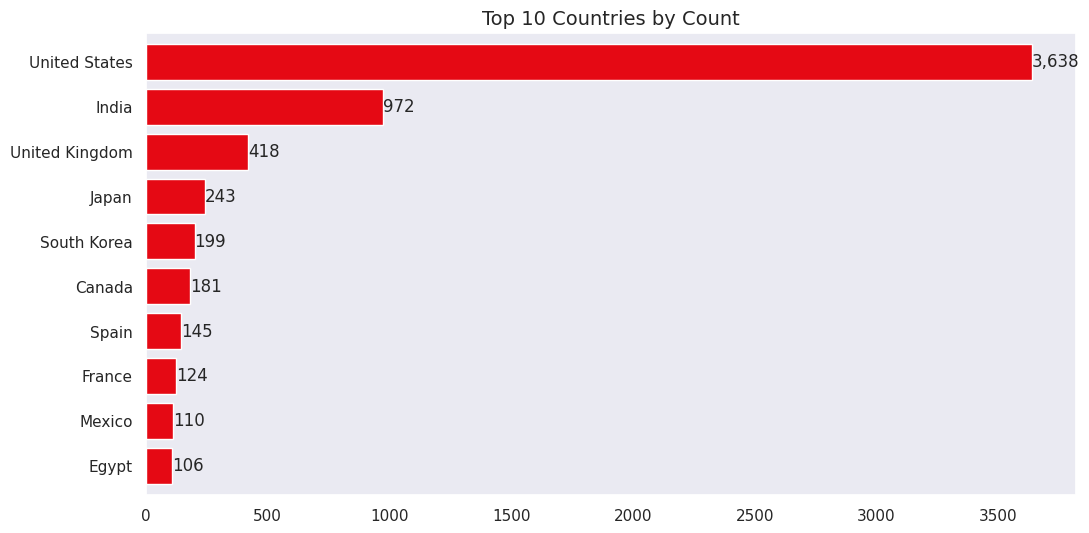

In [18]:
# Count the occurrences of each country
country_counts = df['country'].value_counts()

# Select the top 10 countries by count
top_countries = country_counts.head(10)

# Create a horizontal bar chart
plt.figure(figsize=(12, 6))
ax = top_countries.plot(kind='barh', color='#E50914', width=0.8)  # Adjust width to reduce gap

# Add count values next to the bars with thousands separator
for index, value in enumerate(top_countries):
    formatted_value = '{:,}'.format(value)
    plt.text(value, index, formatted_value, ha='left', va='center', fontsize=12)

# Customize the chart
plt.xlabel('')
plt.ylabel('')
plt.title('Top 10 Countries by Count', size = 14)

# Display the chart
plt.gca().invert_yaxis()
plt.grid(False)
plt.show()



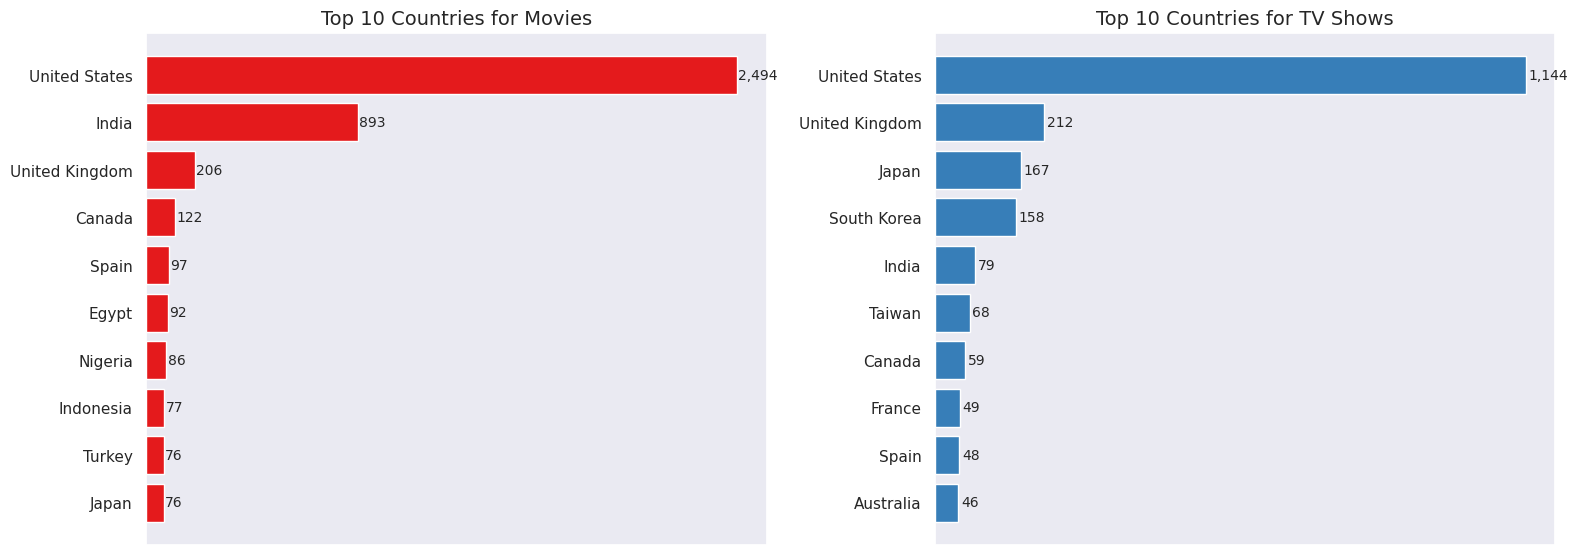

In [19]:
# Count occurrences of each country for movies
movie_counts = df[df['type'] == 'Movie']['country'].value_counts().head(10)

# Count occurrences of each country for TV shows
tv_show_counts = df[df['type'] == 'TV Show']['country'].value_counts().head(10)

# Sort movie counts in descending order
movie_counts = movie_counts.sort_values(ascending=False)

# Use an existing diverging color palette (e.g., RdBu)
colors = sns.color_palette("Set1")

# Create subplots for movies and TV shows side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Movies chart
axes[0].barh(movie_counts.index, movie_counts.values, color=colors[0])
for i, v in enumerate(movie_counts.values):
    axes[0].text(v + 5, i, f'{v:,}', va='center', fontsize=10)

axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Top 10 Countries for Movies', size = 14)
axes[0].invert_yaxis()  # Invert y-axis to display the highest count at the top

# TV Shows chart
axes[1].barh(tv_show_counts.index, tv_show_counts.values, color=colors[1])
for i, v in enumerate(tv_show_counts.values):
    axes[1].text(v + 5, i, f'{v:,}', va='center', fontsize=10)

axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('Top 10 Countries for TV Shows', size = 14)
axes[1].invert_yaxis()  # Invert y-axis

# Adjust spacing between subplots
plt.tight_layout()

#Hide x-lables
for ax in axes:
    ax.set_xticks([])

# Remove grid lines
for ax in axes:
    ax.grid(False)

# Show the combined chart
plt.show()


## Movie and TV Show Duration

- ~80% of the movies are less than 2 hours long <br><br>
- ~91% of TV Shows have 3 or less seasons

In [20]:
# Create Separate DataFrames for Movies and TV Shows
movies = df[df['type'] == 'Movie']
pd.DataFrame(movies)
shows = df[df['type'] == 'TV Show']
pd.DataFrame(shows)

# Variable for number of seasons
shows['num_seasons'] = shows['duration'].str.extract('(\d+)').astype(int)

# Variable for movie duration in minutes and hours
movies['duration_mins'] = movies['duration'].str.extract('(\d+)').astype(int)
movies['duration_hours'] = movies['duration_mins']/60.0

# Define the bins and labels for duration groups
bins = [0, 1, 2, 3, float('inf')]
labels = ['<1 hour', '1-2 hours', '2-3 hours', '>3 hours']

# Use pd.cut to create the 'duration_group' column
movies['duration_group'] = pd.cut(movies['duration_hours'], bins=bins, labels=labels, right=False)


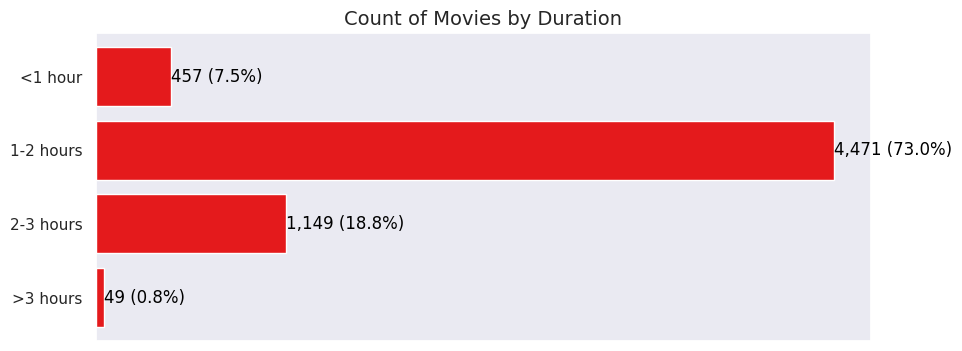

In [21]:
# Assuming 'movies' is your DataFrame
duration_order = ['<1 hour', '1-2 hours', '2-3 hours', '>3 hours']
duration_counts = movies['duration_group'].value_counts().loc[duration_order]

# Calculate the total number of movies
total_movies = duration_counts.sum()

# Create a horizontal bar chart with a divergent color palette
plt.figure(figsize=(10, 4))
colors = sns.color_palette("Set1")

# Bar chart
positions = range(len(duration_counts))
bars = plt.barh(positions, duration_counts.values[::-1], color=colors[0])

# Add labels and title
plt.xlabel('')
plt.title('Count of Movies by Duration', size=14)

# Display the counts and percentages on the bars
for bar, count in zip(bars, duration_counts.values[::-1]):  # Reverse the values
    percentage = (count / total_movies) * 100
    plt.text(count, bar.get_y() + bar.get_height() / 2, f'{count:,} ({percentage:.1f}%)', va='center', fontsize=12, color='black')

# Set y-axis labels in reverse order
plt.yticks(positions, duration_order[::-1])  # Reverse the labels

# Show the chart
plt.grid(False)
plt.xticks([])
plt.show()


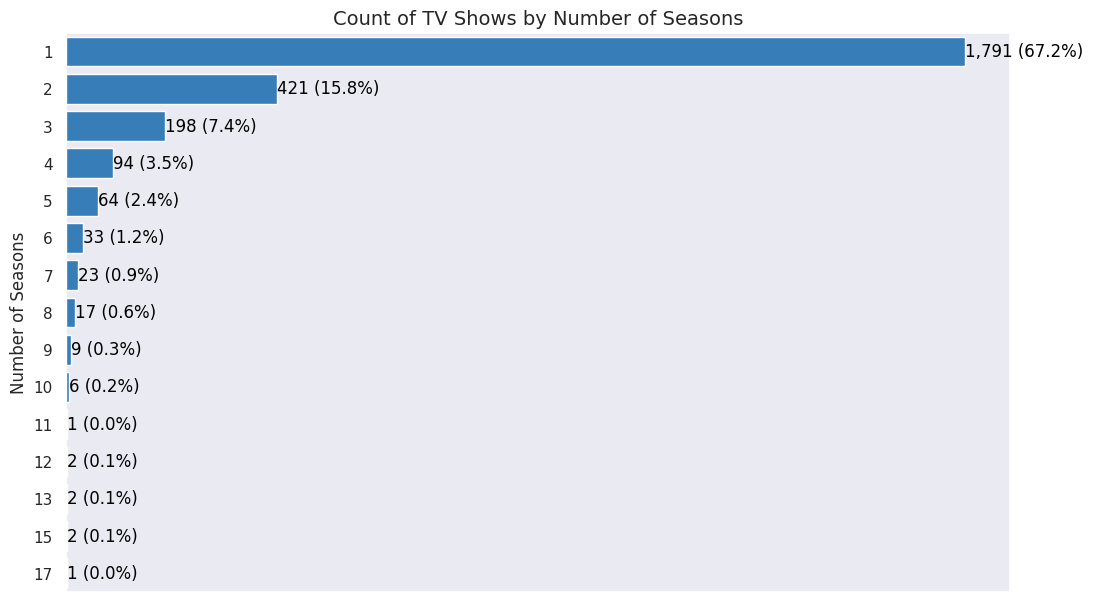

In [22]:
# Count the number of TV shows for each number of seasons and sort in descending order
num_seasons_counts = shows['num_seasons'].value_counts().sort_index(ascending=False)

# Calculate the total number of TV shows
total_shows = num_seasons_counts.sum()

# Create a horizontal bar chart with a divergent color palette
plt.figure(figsize=(10, 6))

# Create a subplot with 1 row and 1 column
plt.subplot(1, 1, 1)

# Reduce the gap between bars by adjusting aspect ratio and spacing
plt.tight_layout(pad=0.2)

colors = sns.color_palette("Set1")

# Bar chart
positions = range(len(num_seasons_counts))
plt.barh(positions, num_seasons_counts, color=colors[1])

# Add labels and title
plt.ylabel('Number of Seasons')
plt.title('Count of TV Shows by Number of Seasons', size = 14)

# Invert y-axis to display the highest count at the top
plt.gca().invert_yaxis()

# Display the counts and percentages on the bars
for i, count in enumerate(num_seasons_counts):
    percentage = (count / total_shows) * 100
    plt.text(count, i, f'{count:,} ({percentage:.1f}%)', va='center', fontsize=12, color='black')

# Remove x-axis values
plt.xticks([])

# Set y-axis ticks to match the available values
plt.yticks(positions, num_seasons_counts.index)

# Adjust the y-axis limits to ensure the first and last rows are fully visible
plt.ylim(min(positions) - 0.5, max(positions) + 0.5)

# Show the chart
plt.grid(False)
plt.show()


## Analysis by Genre
Top 3 Genres:<br>
1) International <br>
2) Drama<br>
3) Comedy<br>

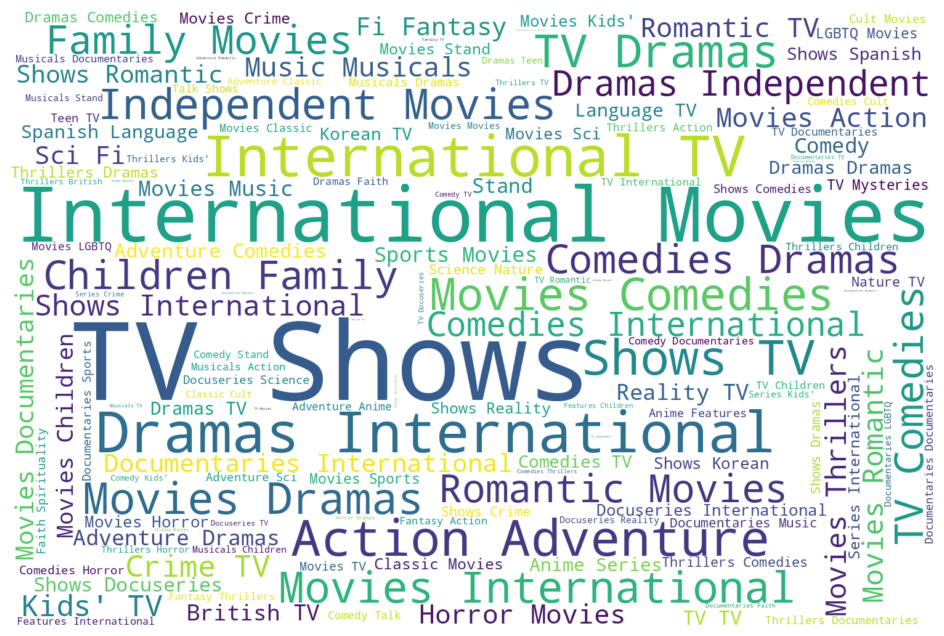

In [23]:
# Assuming 'df' is your DataFrame with a 'description' column
text = " ".join(df['listed_in'].dropna())

# Create the WordCloud object with larger dimensions
wordcloud = WordCloud(width=1500, height=1000, background_color='white').generate(text)

# Create a figure and plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()


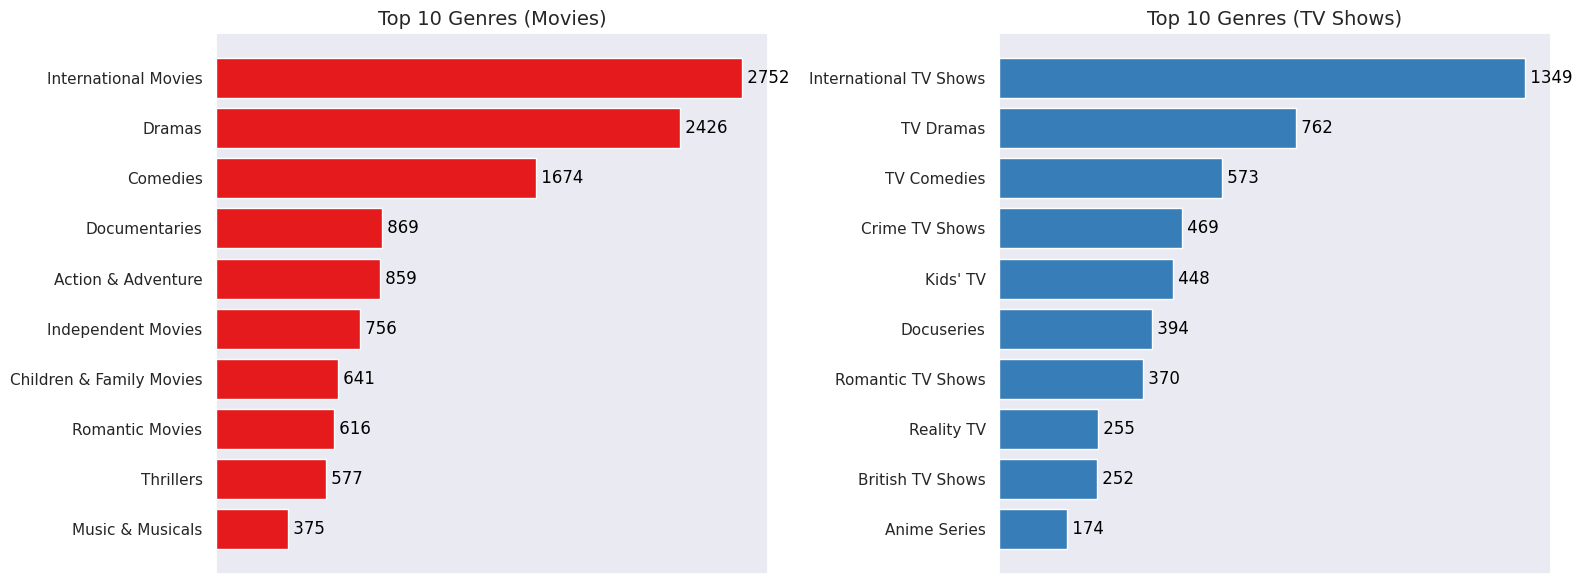

In [24]:
# Initialize color palettes
colors_movies = sns.color_palette("Set1")[0]
colors_tv_shows = sns.color_palette("Set1")[1]

# Calculate the top 10 genres for movies and TV shows
movies_df = df[df['type'] == 'Movie']
tv_shows_df = df[df['type'] == 'TV Show']

genre_counts_movies = movies_df['listed_in'].str.split(', ').explode().value_counts()
genre_counts_tv_shows = tv_shows_df['listed_in'].str.split(', ').explode().value_counts()

top_10_genres_movies = genre_counts_movies.head(10).sort_values(ascending=False)
top_10_genres_tv_shows = genre_counts_tv_shows.head(10).sort_values(ascending=False)

# Create a bar chart for the top 10 genres for movies and TV shows side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart for movies
ax1.barh(top_10_genres_movies.index[::-1], top_10_genres_movies.values[::-1], color=colors_movies)
ax1.set_title('Top 10 Genres (Movies)', fontsize=14)
ax1.grid(False)  # Remove gridlines
ax1.set_xticks([])  # Remove x-axis labels

# Display counts next to the bars for movies
for index, value in enumerate(top_10_genres_movies.values[::-1]):
    ax1.text(value, index, f' {value}', va='center', fontsize=12, color='black')

# Bar chart for TV shows
ax2.barh(top_10_genres_tv_shows.index[::-1], top_10_genres_tv_shows.values[::-1], color=colors_tv_shows)
ax2.set_title('Top 10 Genres (TV Shows)', fontsize=14)
ax2.grid(False)  # Remove gridlines
ax2.set_xticks([])  # Remove x-axis labels

# Display counts next to the bars for TV shows
for index, value in enumerate(top_10_genres_tv_shows.values[::-1]):
    ax2.text(value, index, f' {value}', va='center', fontsize=12, color='black')

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()



## Directors With Most Occurences: USA, India, UK

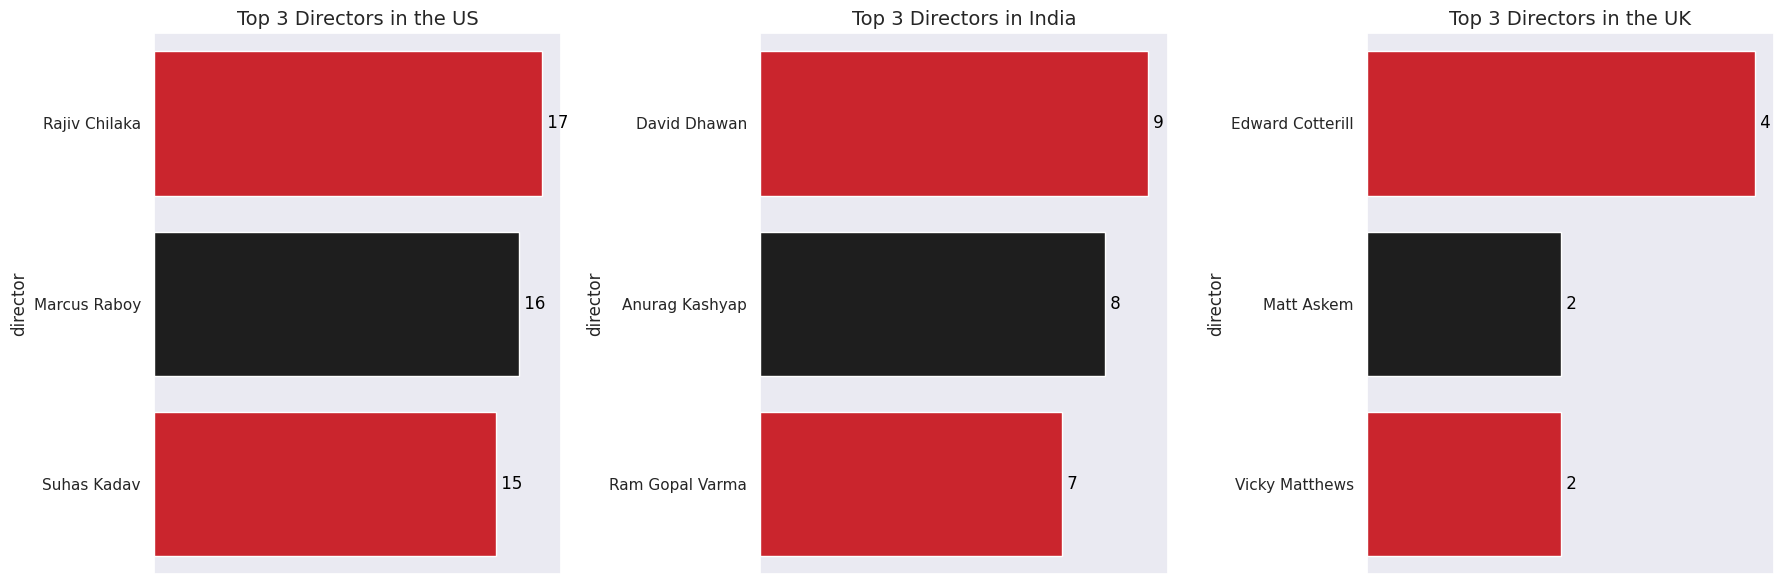

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame 'df' with columns 'director', 'country', and 'type'

# Filter the DataFrame for non-'Unknown' directors
filtered_df = df[df['director'] != 'Unknown']

# Get the top 3 directors for each country
top_3_directors_us = filtered_df[filtered_df['country'] == 'United States']['director'].str.split(', ').explode().value_counts().head(3)
top_3_directors_india = filtered_df[filtered_df['country'] == 'India']['director'].str.split(', ').explode().value_counts().head(3)
top_3_directors_uk = filtered_df[filtered_df['country'] == 'United Kingdom']['director'].str.split(', ').explode().value_counts().head(3)

# Define Netflix color palettes
netflix_colors = ["#E50914", "#1E1E1E"]  # Darker shade for the second color

# Create a bar chart for the top 3 directors in the US
plt.figure(figsize=(18, 6))

# Bar chart for the US
plt.subplot(1, 3, 1)
sns.barplot(y=top_3_directors_us.index, x=top_3_directors_us.values, palette=netflix_colors)
plt.title('Top 3 Directors in the US', fontsize=14)
plt.xlabel('')
plt.grid(False)  # Remove grid lines
plt.xticks([])  # Remove x-axis labels

# Display counts next to the bars for the US
for index, value in enumerate(top_3_directors_us.values):
    plt.text(value, index, f' {value}', va='center', fontsize=12, color='black')

# Bar chart for India
plt.subplot(1, 3, 2)
sns.barplot(y=top_3_directors_india.index, x=top_3_directors_india.values, palette=netflix_colors)
plt.title('Top 3 Directors in India', fontsize=14)
plt.xlabel('')
plt.grid(False)  # Remove grid lines
plt.xticks([])  # Remove x-axis labels

# Display counts next to the bars for India
for index, value in enumerate(top_3_directors_india.values):
    plt.text(value, index, f' {value}', va='center', fontsize=12, color='black')

# Bar chart for the UK
plt.subplot(1, 3, 3)
sns.barplot(y=top_3_directors_uk.index, x=top_3_directors_uk.values, palette=netflix_colors)
plt.title('Top 3 Directors in the UK', fontsize=14)
plt.xlabel('')
plt.grid(False)  # Remove grid lines
plt.xticks([])  # Remove x-axis labels

# Display counts next to the bars for the UK
for index, value in enumerate(top_3_directors_uk.values):
    plt.text(value, index, f' {value}', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()


## Actors With Most Occurences: USA, India, UK

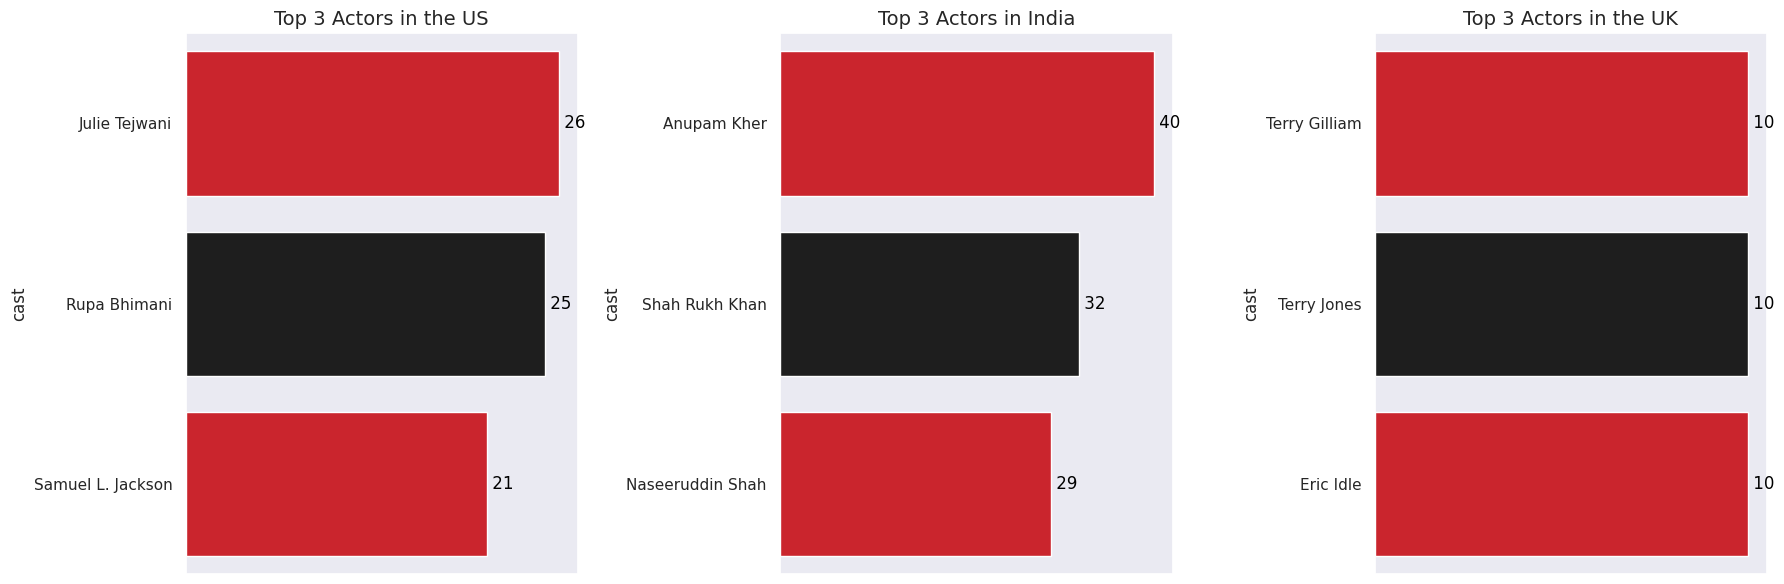

In [26]:
# Filter the DataFrame for non-'Unknown' cast members
filtered_df = df[df['cast'] != 'Unknown']

# Get the top 3 actors for each country
top_3_actors_us = filtered_df[filtered_df['country'] == 'United States']['cast'].str.split(', ').explode().value_counts().head(3)
top_3_actors_india = filtered_df[filtered_df['country'] == 'India']['cast'].str.split(', ').explode().value_counts().head(3)
top_3_actors_uk = filtered_df[filtered_df['country'] == 'United Kingdom']['cast'].str.split(', ').explode().value_counts().head(3)

# Define Netflix color palettes
netflix_colors = ["#E50914", "#1E1E1E"]  # Darker shade for the second color

# Create a bar chart for the top 3 actors in the US
plt.figure(figsize=(18, 6))

# Bar chart for the US
plt.subplot(1, 3, 1)
sns.barplot(y=top_3_actors_us.index, x=top_3_actors_us.values, palette=netflix_colors)
plt.title('Top 3 Actors in the US', fontsize=14)
plt.xlabel('')
plt.grid(False)  # Remove grid lines
plt.xticks([])  # Remove x-axis labels

# Display counts next to the bars for the US
for index, value in enumerate(top_3_actors_us.values):
    plt.text(value, index, f' {value}', va='center', fontsize=12, color='black')

# Bar chart for India
plt.subplot(1, 3, 2)
sns.barplot(y=top_3_actors_india.index, x=top_3_actors_india.values, palette=netflix_colors)
plt.title('Top 3 Actors in India', fontsize=14)
plt.xlabel('')
plt.grid(False)  # Remove grid lines
plt.xticks([])  # Remove x-axis labels

# Display counts next to the bars for India
for index, value in enumerate(top_3_actors_india.values):
    plt.text(value, index, f' {value}', va='center', fontsize=12, color='black')

# Bar chart for the UK
plt.subplot(1, 3, 3)
sns.barplot(y=top_3_actors_uk.index, x=top_3_actors_uk.values, palette=netflix_colors)
plt.title('Top 3 Actors in the UK', fontsize=14)
plt.xlabel('')
plt.grid(False)  # Remove grid lines
plt.xticks([])  # Remove x-axis labels

# Display counts next to the bars for the UK
for index, value in enumerate(top_3_actors_uk.values):
    plt.text(value, index, f' {value}', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()
